# Cloud Super-resolution

In this tutorial we will load a test cloud (that was not used for training). Create a coarse version of it, and use it to generate a new consistent higher resolution cloud using diffusion posterior sampling technique.

In [1]:
try: # installing all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Similarly to tutorial 01, we will start by importing required modules, creating a pipeline and downloading the pretrained state.

In [2]:
import cloudy
import torch


pipeline = cloudy.create_pipeline('./test')
pipeline.download_pretrained()  # Comment if it is already downloaded
recorder = pipeline.create_recorder()

As part of the pretrained data, there are 16 test clouds in encoded as their latent representation.

In [3]:
ref_latent = pipeline.get_test_latent(8)

/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


The `decode_latent` method can be used when there is no intention of training the decoder part. This method assumes a frozen decoder, meaning that only latent gradients are back-propagated (if any). Because the representation might struggle with exact 0 values, a clamp function to guarantee correct densities is needed.

In [4]:
ref_grid = pipeline.decode_latent(ref_latent)
ref_grid = pipeline.clean_volume(ref_grid)

Let's take a look at this cloud.

Rendering captures: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


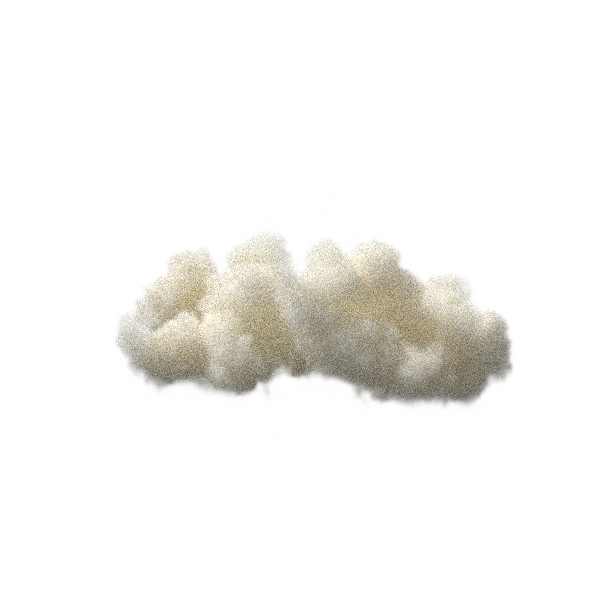

In [5]:
recorder.new_keyframe(recorder.add_capture_volume(ref_grid, samples=32))
recorder.show_clip(1)  # shows the last frame

Now we can proceed with the `coarser_grid` method to downsample using trilinear interpolation. Also, we obtain the coarse grid used as reference.

Rendering captures: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


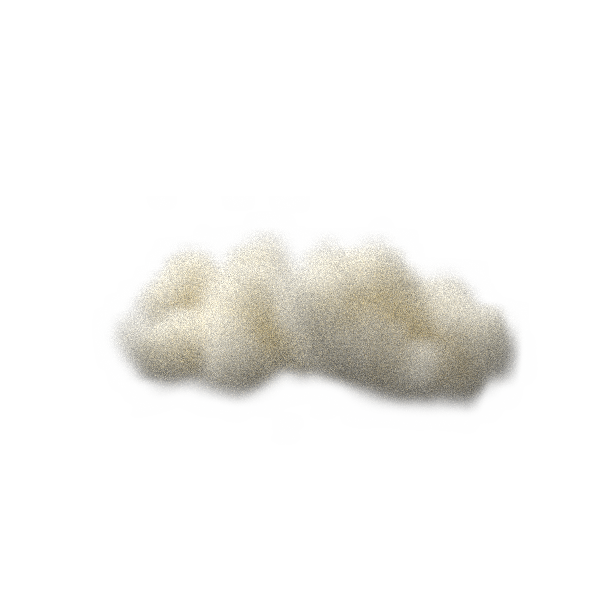

In [6]:
def coarser_grid(g: torch.Tensor, levels: int) -> torch.Tensor:
    g = g.unsqueeze(0).permute(0, 4, 1, 2, 3)  # channels first
    for _ in range(levels):
        g = torch.nn.functional.interpolate(g, scale_factor=0.5, mode='trilinear', align_corners=True)
    return g.permute(0, 2, 3, 4, 1)[0]  # back to channels last


coarse_grid = coarser_grid(ref_grid, 2)

recorder.new_keyframe(recorder.add_capture_volume(coarse_grid, samples=32))
recorder.show_clip(1)

In order to sample $p(x|y)$ we use an overload of `sample_volume` receiving the measurement $y$ and the differentiable process $\mathcal{A}$. Parameter `guiding_strength` can be used to enforce prior (close to $0$) or observations (greater than $1$).

The `sample_volume` method allows a parameter to describe a criteria to guide the generation towards a posterior $p(x|y)$. The criteria function is needed to compute the loss $\|y - \mathcal{A}(\hat{x})\|^2_2$. Here, $y$ is an observation and $\mathcal{A}$ is a forward operator that synthesizes $y$ from an underlying signal $\hat{x}$.  

In this example $\hat{x}$ will be the sampled volume and $\mathcal{A}$ considers the downgrading to a coarser level, i.e.: $\mathcal{A}(\hat{x})=\mathcal{C}(\hat{x})$.

> Note: The diffuser works in the space of latent representations. Nevertheless, the method `sample_volume` already includes the decoding to a volume, i.e., in this case, $\hat{x}$ refers to a volume grid, not a latent.

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Rendering captures: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


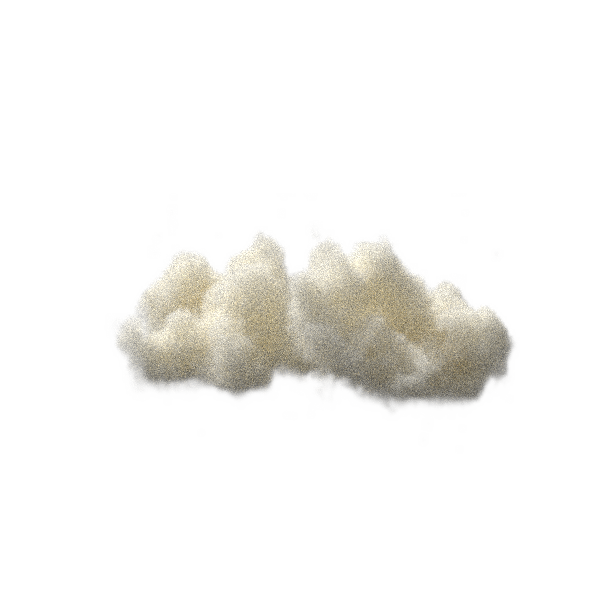

In [7]:
grid = pipeline.sample_volume(
    resolution=128,
    samples=100,
    scheduler_gamma=1.0,
    y=coarse_grid,
    A=lambda v: coarser_grid(v, 2),
    guiding_strength=1.0
)

recorder.new_keyframe(recorder.add_capture_volume(grid, samples=32))
recorder.show_clip(1)

Let's show the 3 collected frames to see the resemblance to the original signal. 

Rendering captures: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


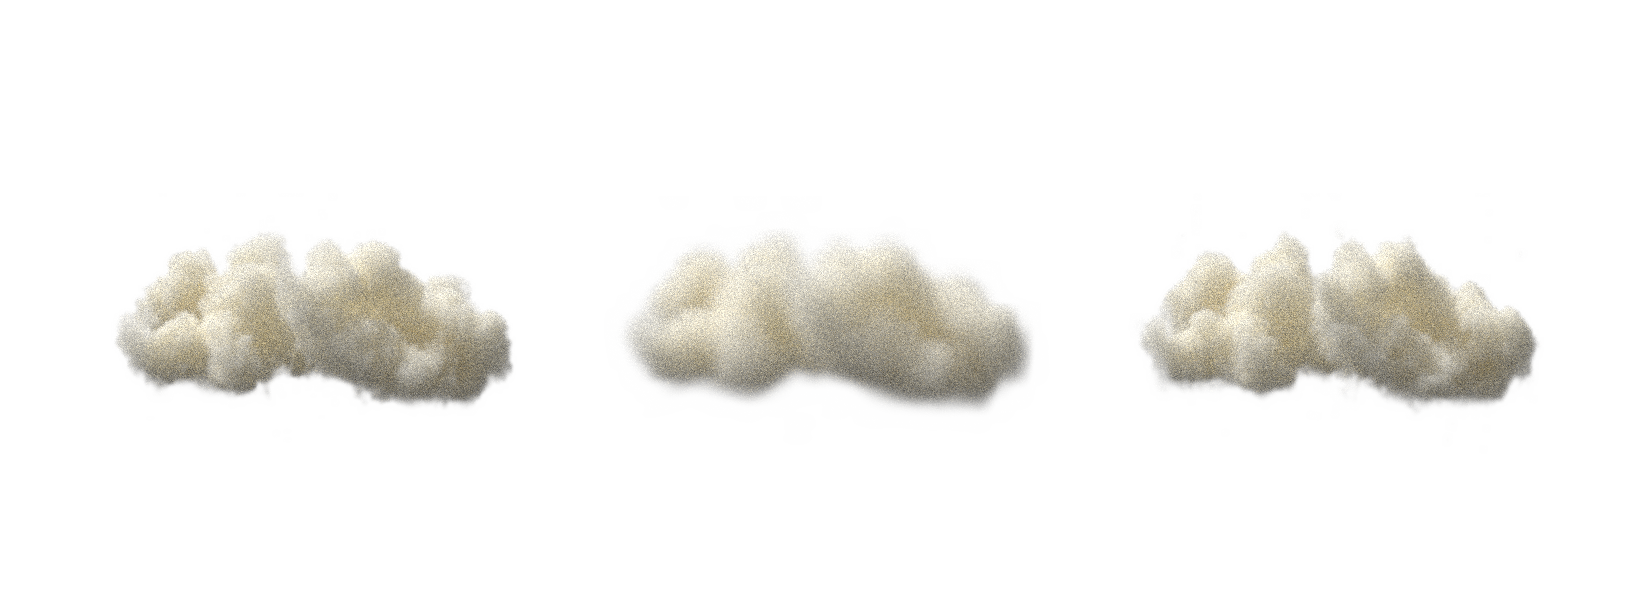

In [8]:
recorder.show_clip(3)  # show the 3 images together